In [1]:
###### Applications Lab #4-- ATOC7500 Objective Analysis - FFT Christman Field
###### last updated October 19, 2020
###### Data from Libby Barnes (CSU), Coded by Jennifer Kay (University of Colorado) and Bryan Mundhenk (CSU)
###### Reviewed by Vineel Yettella, Elizabeth Maroon (University of Colorado)

#import modules
import numpy as np   #for calculations
import matplotlib.pyplot as plt  #for plotting
%matplotlib inline  
import pandas as pd  #for reading in data
import datetime    #for manipulation by dtae
import collections  #for additional dictionary functionality
from matplotlib.gridspec import GridSpec #for subplots
import scipy.signal as signal #for signal processing
import scipy.stats as stats

In [2]:
def create_normalized_redfit(data_length,Te):
    freq = np.arange(0,(data_length/2)+1,1)/float(data_length) # to Nyquist
    red_fit = (2 * Te)/(1 + ((2*np.pi*freq)**2)*(Te**2)) # After Hartmann 6.64, 6.91
    return red_fit/np.sum(red_fit)
def create_f_bounds(alpha,dof,red_fit_n):
    f_ratio = stats.f.ppf(alpha,dof,200) # Note: 200 = large degree of freedom for red noise
    return f_ratio*red_fit_n

In [3]:
## Read in the data
filename = 'Christman_data_nomissing.csv'
data_all=pd.read_csv(filename,sep=',')
data_all.head()

,day,hour,temp_F,RH,dewtemp_F,wind_mph,wind_dir,windgust,windgust_dir,pres_Hg,SOLIN_Wm2,Prec_inches
0,1/1/13,0:00,13.0,82.7,8.7,1.3,0,4.5,12,846.09,0.0,0.0
1,1/1/13,1:00,10.8,84.2,7.0,1.7,350,3.6,354,846.18,0.0,0.0
2,1/1/13,2:00,9.7,82.4,5.5,1.5,331,4.9,349,846.62,0.0,0.0
3,1/1/13,3:00,8.4,80.9,3.8,0.7,319,3.9,348,847.19,0.0,0.0
4,1/1/13,4:00,7.8,82.6,3.6,0.6,228,2.6,221,847.09,0.0,0.0


In [4]:
## Calculate the temperature anomaly and set that equal to the variable "data"
foo=data_all['temp_F']
data=foo-np.mean(foo)
var_str = "Temperature"
data_units = "F"

In [5]:
### Calculate lag-1 autocorrelation and e-folding time of data
rho,lag1_p = stats.pearsonr(data[0:len(data)-1],data[1:len(data)]) # rho = lag1_r
Te = -1./np.log(rho) # After Hartmann 6.4 with delta t = 1
print(var_str,'lag-1 autocorrelation =',round(rho,2),'and Te =',round(Te,2),'hours')

Temperature lag-1 autocorrelation = 0.99 and Te = 100.92 hours


In [15]:
print(rho)

0.9901400706098124


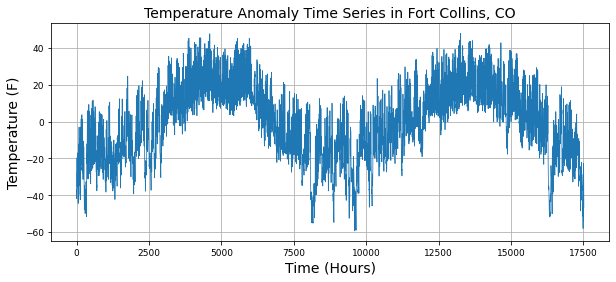

In [16]:
## Plot data
fig = plt.figure(figsize=(10,4))
plt.plot(data, lw=.75)
plt.ylabel(var_str+" ("+data_units+")",fontsize=14)
plt.xlabel('Time (Hours)',fontsize=14)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.title(var_str+" Anomaly Time Series in Fort Collins, CO",fontsize=14)
plt.grid()
#plt.savefig('XX.pdf', dpi=300, format='png')

In [7]:
alpha = 0.99 ## set statistical significance level

##### METHOD #1 - Numpy Method - Calculate FFT
freq = np.fft.rfftfreq(len(data),d=1.)
A = np.fft.rfft(data)
ps = (np.abs(A)**2)/2.
ps_n = (np.abs(A)**2)/np.sum(np.abs(A)**2)
Ao = ps[0]
red_fit_n = create_normalized_redfit(len(data),Te)
f_bounds = create_f_bounds(alpha,2*1,red_fit_n)

In [8]:
# Find the significant spectral peaks
for i in range(len(ps_n)):
    if (ps_n[i] - f_bounds[i]) > 1e-03:  
        #Question: why 1e-03?  This choice trying to select peaks that are well above 99% threshold.
        print('##### FOUND IT - spectral peak exceeds red noise ####')
        print('exceeds by...',ps_n[i]-f_bounds[i])
        print('at frequency....',freq[i])
        print('which in days is...',(1/freq[i])/24.)
        
## for reference -- what is 12-hourly, daily, and yearly in frequency?
print('XXXX FOR REFERENCE XXXX')
print('12-hourly in frequency:',round(1/12,2))
print('24-hourly/daily in frequency:',round(1/24,2))
print('yearly in frequency:',round(1/(24*365),5))  

##### FOUND IT - spectral peak exceeds red noise ####
exceeds by... 0.5163757684804364
at frequency.... 0.00011415525114155251
which in days is... 365.0
##### FOUND IT - spectral peak exceeds red noise ####
exceeds by... 0.11520792476140507
at frequency.... 0.041666666666666664
which in days is... 1.0
##### FOUND IT - spectral peak exceeds red noise ####
exceeds by... 0.001071441733025088
at frequency.... 0.04178082191780822
which in days is... 0.9972677595628414
##### FOUND IT - spectral peak exceeds red noise ####
exceeds by... 0.003890534638353134
at frequency.... 0.08333333333333333
which in days is... 0.5
XXXX FOR REFERENCE XXXX
12-hourly in frequency: 0.08
24-hourly/daily in frequency: 0.04
yearly in frequency: 0.00011


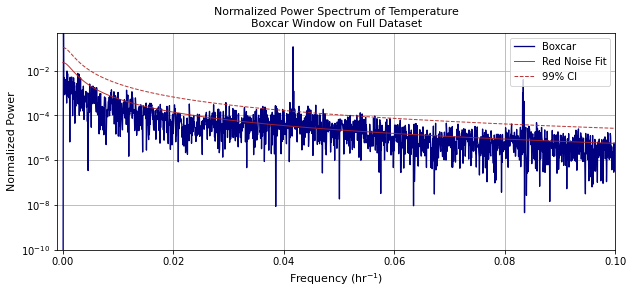

In [31]:
### Plot the results
fig = plt.figure(figsize=(10,4))
method_str = "Boxcar Window on Full Dataset"
plt.plot(freq,ps_n, color='navy', lw=1.3, label='Boxcar')
plt.plot(freq,red_fit_n, color='firebrick', lw=1, alpha=0.9, label='Red Noise Fit') # freq plots 0...0.5
plt.plot(freq,f_bounds, color='firebrick', lw=1, ls='--', alpha=0.9, label=str(int(alpha*100))+'% CI')
#plt.ylim(0.0,0.15)
plt.ylim(10**(-10),0.5)
plt.xlim(-0.001,0.1)
plt.xlabel("Frequency (hr$^{-1}$)",fontsize=11)
plt.ylabel("Normalized Power",fontsize=11)
plt.title("Normalized Power Spectrum of "+var_str+"\n"+method_str,fontsize=11)
plt.legend(loc='upper right',fontsize=10)
plt.grid()
plt.yscale('log')

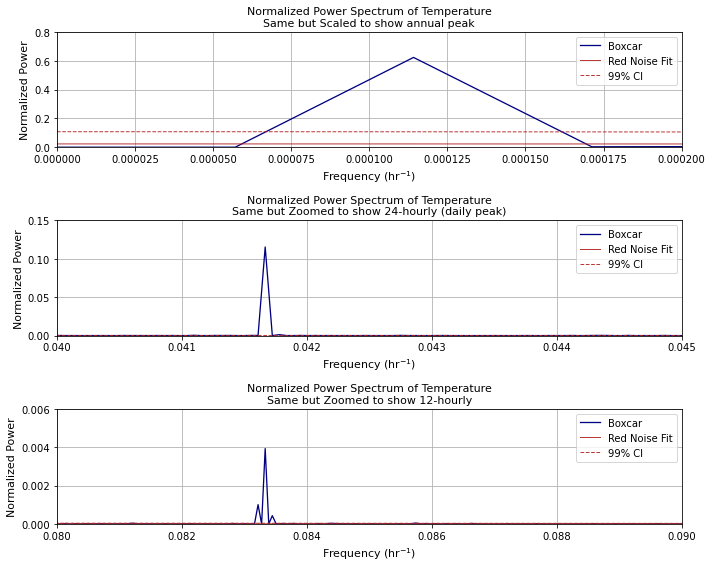

In [10]:
### Plot the results -- zoom in to get a better look at the three large peaks
fig = plt.figure(figsize=(10,8))
gs=GridSpec(3,1)
ax=plt.subplot(gs[0,0])
method_str = "Same but Scaled to show annual peak"
plt.plot(freq,ps_n, color='navy', lw=1.3, label='Boxcar')
plt.plot(freq,red_fit_n, color='firebrick', lw=1, alpha=0.9, label='Red Noise Fit') # freq plots 0...0.5
plt.plot(freq,f_bounds, color='firebrick', lw=1, ls='--', alpha=0.9, label=str(int(alpha*100))+'% CI')
plt.ylim(0.0,0.8)
plt.xlim(0.0,0.0002)
plt.xlabel("Frequency (hr$^{-1}$)",fontsize=11)
plt.ylabel("Normalized Power",fontsize=11)
plt.title("Normalized Power Spectrum of "+var_str+"\n"+method_str,fontsize=11)
plt.legend(loc='upper right',fontsize=10)
plt.grid()
ax=plt.subplot(gs[1,0])
method_str = "Same but Zoomed to show 24-hourly (daily peak)"
plt.plot(freq,ps_n, color='navy', lw=1.3, label='Boxcar')
plt.plot(freq,red_fit_n, color='firebrick', lw=1, alpha=0.9, label='Red Noise Fit') # freq plots 0...0.5
plt.plot(freq,f_bounds, color='firebrick', lw=1, ls='--', alpha=0.9, label=str(int(alpha*100))+'% CI')
plt.ylim(0.0,0.15)
plt.xlim(0.04,0.045)
plt.xlabel("Frequency (hr$^{-1}$)",fontsize=11)
plt.ylabel("Normalized Power",fontsize=11)
plt.title("Normalized Power Spectrum of "+var_str+"\n"+method_str,fontsize=11)
plt.legend(loc='upper right',fontsize=10)
plt.grid()
ax=plt.subplot(gs[2,0])
method_str = "Same but Zoomed to show 12-hourly"
plt.plot(freq,ps_n, color='navy', lw=1.3, label='Boxcar')
plt.plot(freq,red_fit_n, color='firebrick', lw=1, alpha=0.9, label='Red Noise Fit') # freq plots 0...0.5
plt.plot(freq,f_bounds, color='firebrick', lw=1, ls='--', alpha=0.9, label=str(int(alpha*100))+'% CI')
plt.ylim(0.0,0.006)
plt.xlim(0.08,0.09)
plt.xlabel("Frequency (hr$^{-1}$)",fontsize=11)
plt.ylabel("Normalized Power",fontsize=11)
plt.title("Normalized Power Spectrum of "+var_str+"\n"+method_str,fontsize=11)
plt.legend(loc='upper right',fontsize=10)
plt.grid()
fig.tight_layout()

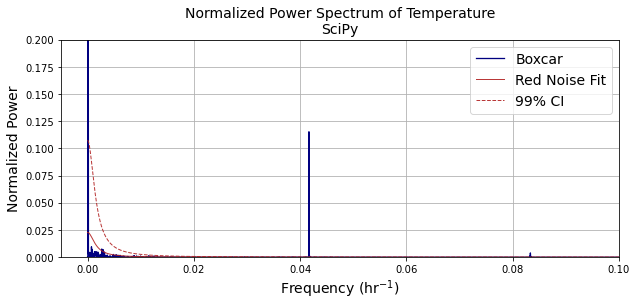

In [11]:
##### METHOD #2 - uses a different python function and library to do the same thing, not a different method mathematically.
## Calculate the power specra using the scipy method... let's see if we get the same answer - we should :).
## http://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.periodogram.html#scipy.signal.periodogram
f,Pxx = signal.periodogram(data,fs=1.,window='boxcar',nfft=None,return_onesided=True,scaling='spectrum')
Pxx_n = Pxx/np.sum(Pxx)

method_str = "SciPy"
fig = plt.figure(figsize=(10,4))
plt.plot(f,Pxx_n, color='navy', lw=1.3, label='Boxcar')
plt.plot(freq,red_fit_n, color='firebrick', lw=1, alpha=0.9, label='Red Noise Fit')
plt.plot(freq,f_bounds, color='firebrick', lw=1, ls='--', alpha=0.9, label=str(int(alpha*100))+'% CI')
plt.ylim(0.0,0.2)
plt.xlim(-0.005,0.1)
plt.xlabel("Frequency (hr$^{-1}$)",fontsize=14)
plt.ylabel("Normalized Power",fontsize=14)
plt.title("Normalized Power Spectrum of "+var_str+"\n"+method_str,fontsize=14)
plt.legend(loc='upper right',fontsize=14)
plt.grid()

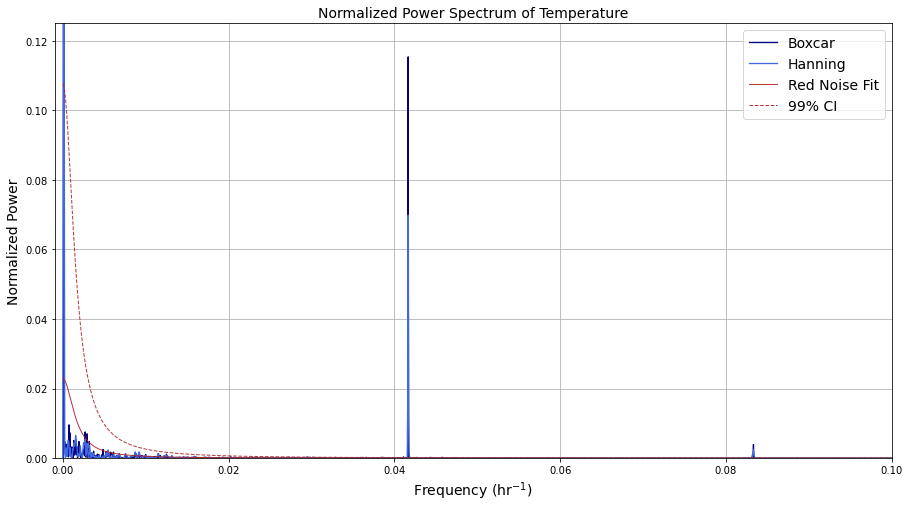

In [36]:
## Note: The benefit of the scipy function is that it has more options so we can for example
## compare results using a Boxcar and Hanning Window.
## You should see a broader peak with the tapered Hanning Window than with the sqaure Boxcar window.
## Can you explain why?  (refer back to lecture #11 of ATOC7500)
## Which window would you prefer??  (Jen prefers the Boxcar for its spectral accuracy... do you agree with her?)
# http://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.periodogram.html#scipy.signal.periodogram

f,Pxx = signal.periodogram(data,fs=1.,window='boxcar',nfft=None,return_onesided=True,scaling='spectrum')
Pxx_n = Pxx/np.sum(Pxx)
f_h,Pxx_h = signal.periodogram(data,fs=1.,window='hanning',nfft=None,return_onesided=True,scaling='spectrum')
Pxx_h_n = Pxx_h/np.sum(Pxx_h)

fig = plt.figure(figsize=(15,8))
plt.plot(f,Pxx_n, color='navy', lw=1.3, label='Boxcar')
plt.plot(f_h,Pxx_h_n, color='royalblue', lw=1.3, label='Hanning')
plt.plot(freq,red_fit_n, color='firebrick', lw=1, alpha=0.9, label='Red Noise Fit')
plt.plot(freq,f_bounds, color='firebrick', lw=1, ls='--', alpha=0.9, label=str(int(alpha*100))+'% CI')
plt.ylim(0.0,0.125)
plt.xlim(-0.001,0.1)
plt.xlabel("Frequency (hr$^{-1}$)",fontsize=14)
plt.ylabel("Normalized Power",fontsize=14)
plt.title("Normalized Power Spectrum of "+var_str,fontsize=14)
plt.legend(loc='upper right',fontsize=14)
plt.grid()

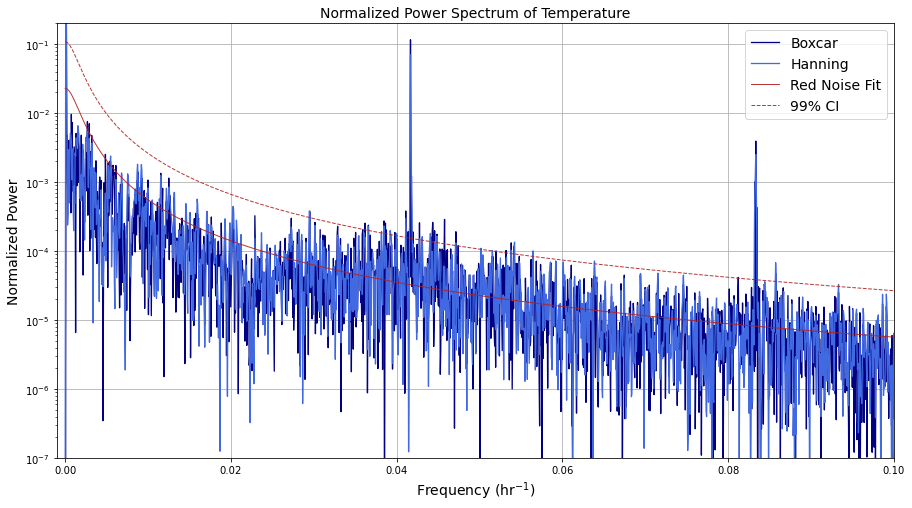

In [35]:
## Note: The benefit of the scipy function is that it has more options so we can for example
## compare results using a Boxcar and Hanning Window.
## You should see a broader peak with the tapered Hanning Window than with the sqaure Boxcar window.
## Can you explain why?  (refer back to lecture #11 of ATOC7500)
## Which window would you prefer??  (Jen prefers the Boxcar for its spectral accuracy... do you agree with her?)
# http://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.periodogram.html#scipy.signal.periodogram

f,Pxx = signal.periodogram(data,fs=1.,window='boxcar',nfft=None,return_onesided=True,scaling='spectrum')
Pxx_n = Pxx/np.sum(Pxx)
f_h,Pxx_h = signal.periodogram(data,fs=1.,window='hanning',nfft=None,return_onesided=True,scaling='spectrum')
Pxx_h_n = Pxx_h/np.sum(Pxx_h)

fig = plt.figure(figsize=(15,8))
plt.plot(f,Pxx_n, color='navy', lw=1.3, label='Boxcar')
plt.plot(f_h,Pxx_h_n, color='royalblue', lw=1.3, label='Hanning')
plt.plot(freq,red_fit_n, color='firebrick', lw=1, alpha=0.9, label='Red Noise Fit')
plt.plot(freq,f_bounds, color='firebrick', lw=1, ls='--', alpha=0.9, label=str(int(alpha*100))+'% CI')
#plt.ylim(0.0,0.2)
plt.ylim(10**(-7),0.2)
plt.xlim(-0.001,0.1)
plt.xlabel("Frequency (hr$^{-1}$)",fontsize=14)
plt.ylabel("Normalized Power",fontsize=14)
plt.title("Normalized Power Spectrum of "+var_str,fontsize=14)
plt.legend(loc='upper right',fontsize=14)
plt.yscale('log')
plt.grid()

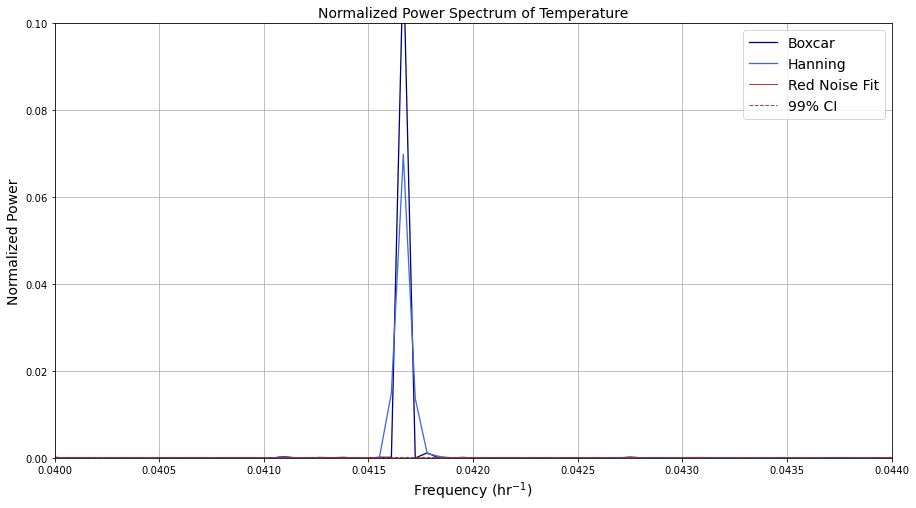

In [13]:
### You need to zoom in to see the extra smoothing caused by the Hanning Window.
fig = plt.figure(figsize=(15,8))
plt.plot(f,Pxx_n, color='navy', lw=1.3, label='Boxcar')
plt.plot(f_h,Pxx_h_n, color='royalblue', lw=1.3, label='Hanning')
plt.plot(freq,red_fit_n, color='firebrick', lw=1, alpha=0.9, label='Red Noise Fit')
plt.plot(freq,f_bounds, color='firebrick', lw=1, ls='--', alpha=0.9, label=str(int(alpha*100))+'% CI')
plt.ylim(0.0,0.10)
plt.xlim(0.04,0.044)
plt.xlabel("Frequency (hr$^{-1}$)",fontsize=14)
plt.ylabel("Normalized Power",fontsize=14)
plt.title("Normalized Power Spectrum of "+var_str,fontsize=14)
plt.legend(loc='upper right',fontsize=14)
plt.grid()